<a href="https://colab.research.google.com/github/Umhyunbin/Education_Committee/blob/main/sentiment_classification_kobert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KoBERT finetuning

In [ ]:
# 환경설정
!pip install numpy==1.23.1 # 버전을 낮춰야 np.bool쪽에서 오류가 안남
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch>=1.8.1

!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Using cached gluonnlp-0.8.0.tar.gz (235 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292696 sha256=280232414946dc248fb2f8ead1b4b866efd942250338a9e45fd7fff95e4545bb
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-f1dpj1a9/kobert-tokenizer_0a3486fd2bd44bf1b670defc13d6cc62
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-f1dpj1a9/kobert-tokenizer_0a3486fd2bd44bf1b670defc13d6cc62
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f5

In [ ]:
# 라이브러리 불러오기
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from google.colab import files

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [ ]:
# koBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

# Tansformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# Torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)

# 데이터셋 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 학습 데이터셋 불러오기
data = pd.read_csv("/content/drive/My Drive/라벨링_대분류_최종.csv", encoding = "utf-8")

In [ ]:
data.head()

,Unnamed: 0,제안이유,대주제
0,0,제안이유\n\n지난 2012년 5월 개정된 「국회법」은 종래 쟁점 안건의 심의과정에...,정치
1,1,제안이유\n\n현행 국회의원 의정활동 지원은 의원 인당 일정금액을 지원하는 방식이 ...,정치
2,2,지난 2012년 5월 개정된 「국회법」은 종래 쟁점 안건의 심의과정에서 빈번하게 발...,정치
3,3,제안이유\n\n국회의 최종적 의사는 헌법 제49조가 정하고 있는 다수결의 원칙에 따...,정치
4,4,제안이유\n\n현행 「국회법」은 위원회의 의사일정과 개회일시를 위원장이 간사와 협의...,정치


In [ ]:
data = data.drop("Unnamed: 0", axis = 1)

# 발의안 대주제 라벨링 데이터 불러오기

In [ ]:
import pandas as pd
import re

# CSV 파일 읽기
df = pd.read_csv("/content/drive/My Drive/발의안학습_labelled.csv", encoding="euc-kr")

text = []

for i in range(len(df)):
    content = df['제안이유 및 주요내용'][i]
    # '제안이유', '주요내용', '및', '■ ', '참고사항' 제거
    content_without_reason = content.replace('제안이유', '').replace('주요내용', '').replace('및', '').replace('■ ', '').replace('참고사항', '')
    # 한글 조사 및 접미사 제거
    content_without_ko = content_without_reason.replace('가.', '').replace('나.', '').replace('다.', '').replace('라.', '').replace('마.', '').replace('바.', '').replace('사.', '').replace('아.', '').replace('자.', '').replace('차.', '').replace('카.', '').replace('타.', '').replace('파.', '').replace('하.', '')
    # 일반적인 단어 제거
    content_without_gen = content_without_ko.replace('경우', '').replace('신설', '').replace('규정', '').replace('지원', '').replace('위원회', '').replace('필요', '').replace('사업', '').replace('기관', '').replace('운영', '')
    content_without_ent = content_without_gen.replace('\n', '')


    # 문장 분할 없이 공백 제거 및 빈 문자열 제거 후 리스트에 추가
    cleaned_content = content_without_gen.strip()
    text.append(cleaned_content)


In [ ]:
text

['우주비행체 등을 생산·제조하는 산업은 국가의 우주산업 발전에 있어 매우 중요한 업무이고, 대다수는 국가  지방자치단체 등에 공급하는 가 많음.\n  그럼에도 우주비행체 개발과 관련된 물품에 대해서는 관세가 면제되지 않아 최종 소비자인 국가나 지방자치단체가 사실상 관세를 부담하게 됨으로써 정부 예산의 비효율성과 불한 행정절차 문제 등이 지적되고 있음.\n  이에 「항공우주산업개발 촉진법」 제2조제3호에 따른 우주비행체의 개발을 목적으로 수입하는 물품 중 국가, 지방자치단체 또는 정부출연연구에 공급하는 물품에 대해서는 관세가 면제되도록 하려는 것임(안 제93조제18호 ).',
 '현행법은 인천국제공항공사, 한국공항공사 등의 공항자가 공항·비행장·항행안전시설을 사용하거나 이용하는 자로부터 사용료를 징수할 수 있도록 하고 있으며, 이에 따라 공항자는 해당 공항을 출발하는 항공편의 승객을 대상으로 공항 사용료를 징수하고 있음.\n  이와 관련하여 공항자는 내부에 따라 국내여객의  2세 이상 13세 미만의 어린이, 장애인, 국가유공자 등에 대해 사용료의 50퍼센트를 감면하고 국제여객의  2세 미만의 어린이, 외교관, 국외입양아동 등에 대해 이를 면제하고 있는데, 현행법이 사용료의 감면에 관한 별도의 을 두고 있지 않아 그 법적 근거가 미흡하다는 지적이 있음.\n  한편, 항공수요  이용객의 증가로 공항 사용료 수입은 증가하는 반면 항공기 운항횟수의 급증에 따른 공항 주변지역의 소음피해 또한 커지고 있는 실정이므로, 사용료 감면 대상에 해당 지역 주민도 포함하도록 할 가 있다는 주장이 있음.\n  이에 현행법에 공항이용객 중 외교관여권 소지자 등에 대하여 사용료의 전부 또는 일부를 면제할 수 있도록 명시하는 한편, 「공항소음 방지  소음대책지역 에 관한 법률」에 따른 소음대책지역 주민도 그 감면 대상에 포함될 수 있도록 하려는 것임(안 제32조제1항 단서 ).',
 '현행법에 따르면 식품의약품안전처장은 어린이급식관리센터가 급식소에 대한 위생  영양관리 을 원활하게 수행

In [ ]:
# 전처리된 내용을 새로운 열로 추가
df['내용'] = text
df = df.drop(['제안이유 및 주요내용', 'Unnamed: 6'], axis = 1)
df.head()

,정치,경제,사회,문화,IT과학,내용
0,0.0,1.0,0.0,0.0,0.0,우주비행체 등을 생산·제조하는 산업은 국가의 우주산업 발전에 있어 매우 중요한 업무...
1,0.0,0.0,1.0,0.0,0.0,"현행법은 인천국제공항공사, 한국공항공사 등의 공항자가 공항·비행장·항행안전시설을 사..."
2,0.0,0.0,1.0,0.0,0.0,현행법에 따르면 식품의약품안전처장은 어린이급식관리센터가 급식소에 대한 위생 영양관...
3,0.0,0.0,1.0,0.0,0.0,현행법에서는 국가와 지방자치단체가 무상으로 하는 보육비용 이외에 어린이집을 설치·하...
4,0.0,0.0,1.0,0.0,0.0,현행법에서 의료기기를 광고하려는 자는 식품의약품안전처장이 정한 심의기준·방법 절차...


In [ ]:
# 레이블 다섯개로 했을 때
# 열 순서를 변경
new_order = ['내용', '정치', '경제', '사회', '문화', 'IT과학']
df = df[new_order]
df.head()

,내용,정치,경제,사회,문화,IT과학
0,우주비행체 등을 생산·제조하는 산업은 국가의 우주산업 발전에 있어 매우 중요한 업무...,0.0,1.0,0.0,0.0,0.0
1,"현행법은 인천국제공항공사, 한국공항공사 등의 공항자가 공항·비행장·항행안전시설을 사...",0.0,0.0,1.0,0.0,0.0
2,현행법에 따르면 식품의약품안전처장은 어린이급식관리센터가 급식소에 대한 위생 영양관...,0.0,0.0,1.0,0.0,0.0
3,현행법에서는 국가와 지방자치단체가 무상으로 하는 보육비용 이외에 어린이집을 설치·하...,0.0,0.0,1.0,0.0,0.0
4,현행법에서 의료기기를 광고하려는 자는 식품의약품안전처장이 정한 심의기준·방법 절차...,0.0,0.0,1.0,0.0,0.0


In [ ]:
# 열 제목에 따라 0부터 4까지 값 부여
labels = {
    '정치': 0,
    '경제': 1,
    '사회': 2,
    '문화': 3,
    'IT과학': 4
}

# 라벨링 함수 정의
def label_row(row):
    for key, value in labels.items():
        if row[key] == 1.0:
            return value
    return -1  # 만약 모든 값이 0이라면 -1 반환

# 라벨링 적용
df['label'] = df.apply(label_row, axis=1)
df = df[df['label'] != -1]
df = df.drop(['정치','경제', '사회', '문화', 'IT과학'], axis = 1)

In [ ]:
df['label'].unique()

array([1, 2, 0, 3, 4])

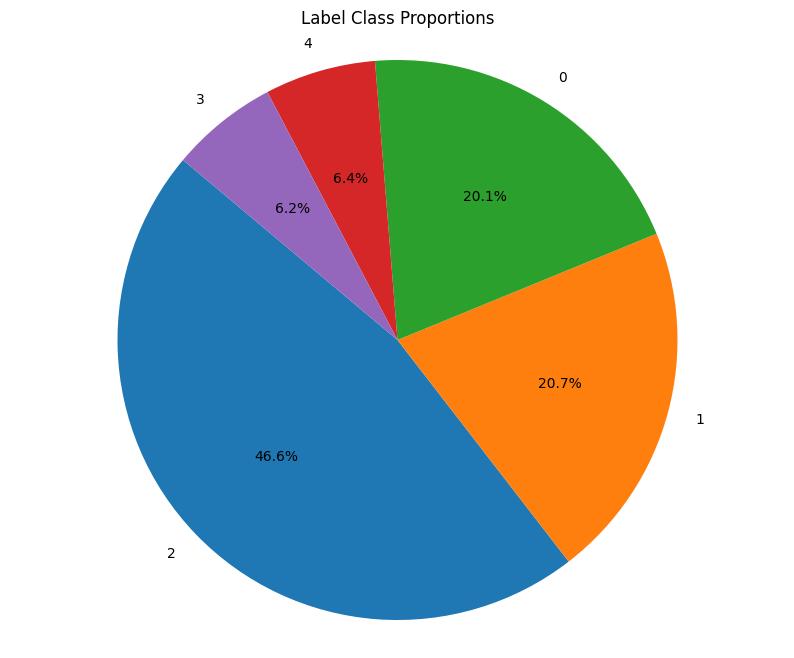

In [ ]:
import matplotlib.pyplot as plt

# 클래스 비율을 계산
class_counts = df['label'].value_counts(normalize=True)

# 파이차트를 위한 데이터와 라벨 준비
labels = class_counts.index
sizes = class_counts.values

# 파이차트 그리기
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 동그란 파이차트를 위해
plt.title('Label Class Proportions')
plt.show()

In [ ]:
# 특수문자 제거
df['내용'] = df['내용'].str.replace(r'[^\w\s]', '', regex=True)

In [ ]:
df['label']

0      1
1      2
2      2
3      2
4      2
      ..
539    4
540    2
541    4
542    4
543    4
Name: label, Length: 468, dtype: int64

In [ ]:
from sklearn.utils import resample

# 다수 클래스 데이터 프레임과 소수 클래스 데이터 프레임 분리
df_majority = df[df['label'] == 2]
df_minority = df[df['label'] == 1]
df_rest = df[df['label'] != 2]

df_majority


,내용,label
1,현행법은 인천국제공항공사 한국공항공사 등의 공항자가 공항비행장항행안전시설을 사용하거...,2
2,현행법에 따르면 식품의약품안전처장은 어린이급식관리센터가 급식소에 대한 위생 영양관...,2
3,현행법에서는 국가와 지방자치단체가 무상으로 하는 보육비용 이외에 어린이집을 설치하는...,2
4,현행법에서 의료기기를 광고하려는 자는 식품의약품안전처장이 정한 심의기준방법 절차에...,2
5,현행법은 보건의료상 필수적이나 시장 기능만으로는 안정공급이 어려운 의약품을 국가필수...,2
...,...,...
518,현행법상 사망신고는 기본적으로 유족에게 일임하고 있어 유족들이 사망신고를 하지 않는...,2
520,현행법은 산업통상자원부장관이 청정생산기술의 보급 기업의 녹색경영 촉진 중소기업에 ...,2
522,현행법은 자동차 운행으로 인하여 사람이 사망 또는 부상하거나 재물이 멸실 또는 훼손...,2
538,현행법은 정보통신망에서 불법정보를 유통하는 것을 금지하고 정보통신망에 유통되는 정보...,2


In [ ]:
# 다수 클래스의 데이터 프레임에서 랜덤으로 샘플링하여 크기를 소수 클래스와 같게 조정
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # 샘플링 without replacement
                                   n_samples=len(df_minority),     # 소수 클래스의 크기에 맞춤
                                   random_state=123) # 재현 가능한 결과를 위한 난수 seed

# 다운샘플링된 다수 클래스 데이터 프레임과 소수 클래스 데이터 프레임을 합침
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# 데이터셋 새로운 균형 확인
print(df_downsampled['label'].value_counts())

label
2    97
1    97
Name: count, dtype: int64


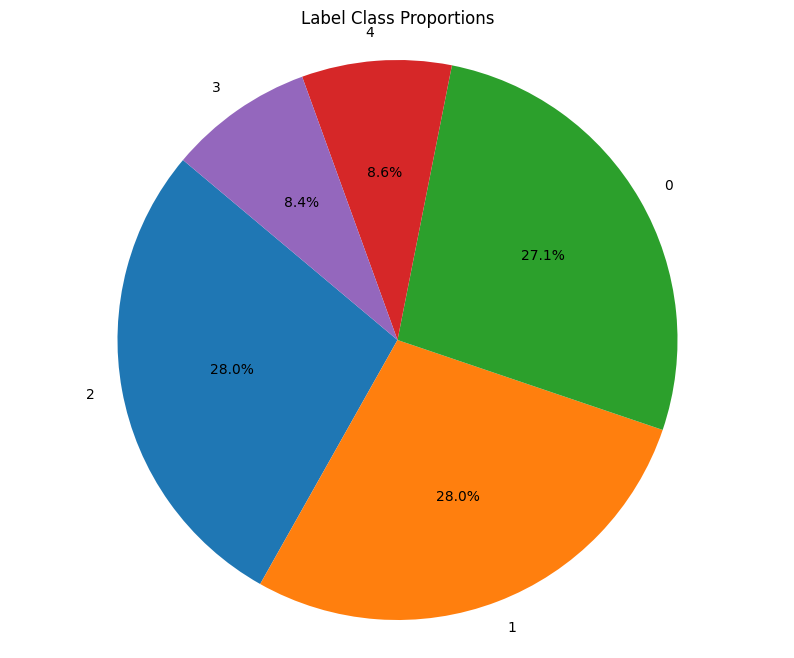

In [ ]:
# 다운샘플링된 다수 클래스 데이터 프레임과 소수 클래스 데이터 프레임을 합침
df = pd.concat([df_majority_downsampled, df_rest])

# 데이터셋 새로운 균형 확인
import matplotlib.pyplot as plt

# 클래스 비율을 계산
class_counts = df['label'].value_counts(normalize=True)

# 파이차트를 위한 데이터와 라벨 준비
labels = class_counts.index
sizes = class_counts.values

# 파이차트 그리기
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 동그란 파이차트를 위해
plt.title('Label Class Proportions')
plt.show()

In [ ]:
col_name = ['내용', 'label']
# CSV 파일 읽기
df_plus = pd.read_csv("/content/drive/My Drive/문화,IT - crawling5.csv", encoding="utf-8", names = col_name)

In [ ]:
df = pd.concat([df, df_plus])

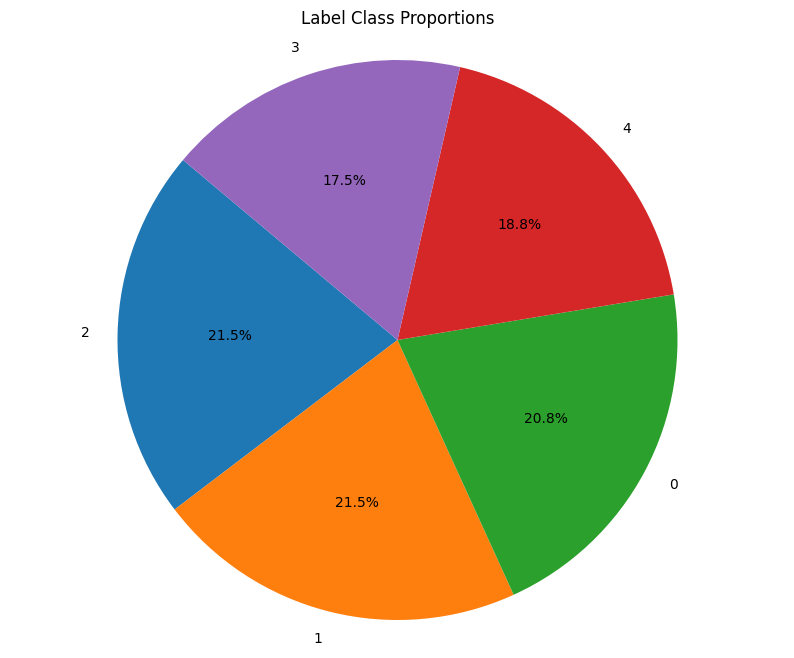

In [ ]:
# 클래스 비율을 계산
class_counts = df['label'].value_counts(normalize=True)

# 파이차트를 위한 데이터와 라벨 준비
labels = class_counts.index
sizes = class_counts.values

# 파이차트 그리기
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 동그란 파이차트를 위해
plt.title('Label Class Proportions')
plt.show()

In [ ]:
df.to_csv("/content/drive/My Drive/propo_train_labeled1.csv", index = False, encoding = 'cp949')

# BERTSentenceTransform 클래스 수정

In [ ]:
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

## 훈련 데이터로 학습

(이 역시, 수동으로 라벨링한 데이터 사용)

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import re

class ClsDataset(Dataset):
    def __init__(self, data):
        self.dataset = data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        text = self.dataset.iloc[index, 0]
        label = self.dataset.iloc[index, 1]
        return text, label

def sampling_func(data, sample_pct, _seed):
    np.random.seed(_seed)
    N = len(data)
    sample_n = int(len(data)*sample_pct) # integer
    sample = data.take(np.random.permutation(N)[:sample_n])
    return sample

def preprocess_data(df):
    def clean_content(content):
        # 특정 문자열 및 조사, 접미사 제거
        content = re.sub(r'(제안이유|주요내용|및|■ |참고사항|가\.|나\.|다\.|라\.|마\.|바\.|사\.|아\.|자\.|차\.|카\.|타\.|파\.|하\.|경우|신설|규정|지원|위원회|필요|사업|기관|운영|\n)', ' ', content)
        # 공백 정리
        content = re.sub(r'\s+', ' ', content).strip()
        return content

    # '내용' 열 전처리
    df['내용'] = df['내용'].apply(clean_content)
    # 한글과 숫자, 공백을 제외한 모든 문자 제거
    df['내용'] = df['내용'].apply(lambda x: re.sub(r'[^가-힣a-zA-Z0-9\s]', '', x))
    # '대주제' 열의 값이 1-5로 되어있는지 확인하고 0-4로 변환
    if '대주제' in df.columns and df['대주제'].between(1, 5).all():
        df['대주제'] = df['대주제'] - 1
    df.drop("소주제", axis = 1)
    return df


In [ ]:
join_df = pd.read_csv("/content/drive/My Drive/labelled - 시트1.csv")

join_df.rename(columns = {"제안내용" : "내용"}, inplace = True)
join_df["대주제"] = join_df["대주제"] - 1
join_df.head()

,내용,대주제,소주제
0,제안이유 및 주요내용\n\n과학기술과 정보통신기술을 통해 창조경제의 기반을 구축하기...,4,1
1,교육과학기술부의 원자력 연구ㆍ개발ㆍ생산ㆍ이용에 관한 업무를 산업통상자원부로 이관하는...,4,1
2,제안이유 및 주요내용\n\n교육과학기술부의 과학기술 정책 기능과 방송통신위원회의 정...,4,0
3,제안이유 및 주요내용\n\n교육과학기술부의 과학기술 정책 기능과 방송통신위원회의 정...,4,0
4,창조 과학을 통한 창조 경제의 기반을 구축하기 위하여 미래창조과학부를 신설하는 내용...,4,4


In [ ]:
# 데이터 불러오기
data = pd.read_csv("/content/drive/MyDrive/대소주제_학습1.csv", encoding = "euc-kr")
data.head()

,내용,대주제,소주제
0,지난 2012년 5월 개정된 국회법은 종래 쟁점 안건의 심의과정에서 빈번하게 발생하...,0,2.0
1,현행 국회의원 의정활동 은 의원 인당 일정금액을 하는 방식이 주를 이루고 있음 의원...,0,2.0
2,지난 2012년 5월 개정된 국회법은 종래 쟁점 안건의 심의과정에서 빈번하게 발생하...,0,2.0
3,국회의 최종적 의사는 헌법 제49조가 정하고 있는 다수결의 원칙에 따라 본회의에서 ...,0,2.0
4,현행 국회법은 의 의사일정과 개회일시를 위원장이 간사와 협의하여 정하도록 하고 있으...,0,2.0


In [ ]:
data = pd.concat([data, join_df], axis=0, ignore_index=True)

data.head()

,내용,대주제,소주제
0,지난 2012년 5월 개정된 국회법은 종래 쟁점 안건의 심의과정에서 빈번하게 발생하...,0,2.0
1,현행 국회의원 의정활동 은 의원 인당 일정금액을 하는 방식이 주를 이루고 있음 의원...,0,2.0
2,지난 2012년 5월 개정된 국회법은 종래 쟁점 안건의 심의과정에서 빈번하게 발생하...,0,2.0
3,국회의 최종적 의사는 헌법 제49조가 정하고 있는 다수결의 원칙에 따라 본회의에서 ...,0,2.0
4,현행 국회법은 의 의사일정과 개회일시를 위원장이 간사와 협의하여 정하도록 하고 있으...,0,2.0


In [ ]:
# 데이터셋 전처리
df = preprocess_data(data)

# 샘플링 (70% 샘플링)
sampled_df = sampling_func(df, 0.7, _seed=42)

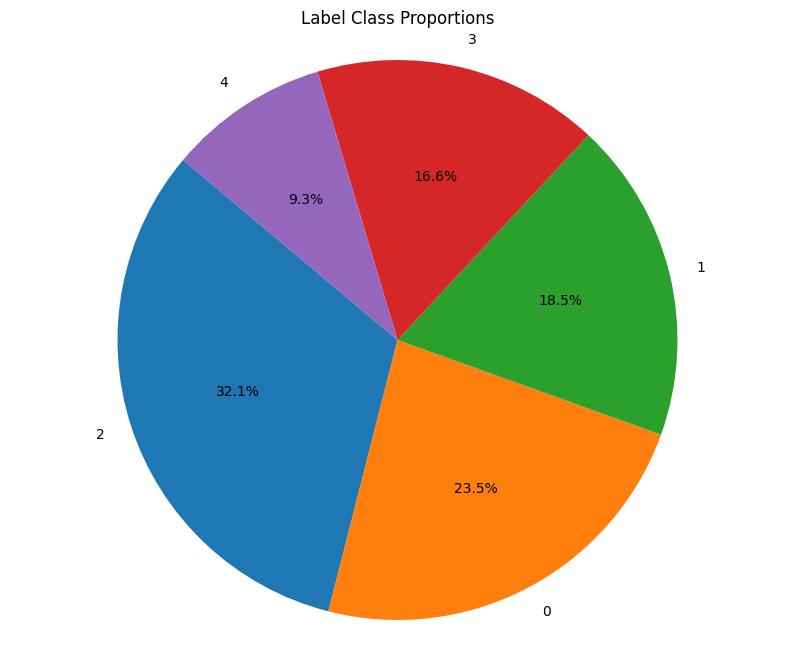

In [ ]:
import matplotlib.pyplot as plt

# 클래스 비율을 계산
class_counts = sampled_df['대주제'].value_counts(normalize=True)

# 파이차트를 위한 데이터와 라벨 준비
labels = class_counts.index
sizes = class_counts.values

# 파이차트 그리기
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 동그란 파이차트를 위해
plt.title('Label Class Proportions')
plt.show()

수집한 데이터의 라벨이 어느 정도 균형을 갖추고 있음을 확인, 불균형의 정도가 심하지 않으므로 자주 분류되는 대주제에 대해 더 잘 분류하도록 불균형을 유지함


In [ ]:
# # 학습 데이터 train, test 분할
# ex = pd.read_csv("/content/drive/My Drive/train_dataset.csv", encoding = 'utf-8')
train, test = train_test_split(sampled_df, test_size=0.2, random_state=42)

In [ ]:
train.to_csv("/content/drive/My Drive/train_최최종.csv", index = False, encoding = 'cp949')
test.to_csv("/content/drive/My Drive/test_최최종.csv", index = False, encoding = 'cp949')

In [ ]:
# index -> 0 : content, 1 : sentiment
train = nlp.data.TSVDataset("/content/drive/MyDrive/train_최최종 - train_최최종.tsv",  encoding = 'utf-8', field_indices=[0, 1], num_discard_samples=1) # num_discard_samples는 상위 몇개 행을 빼고 볼건지
data_predict = nlp.data.TSVDataset("/content/drive/MyDrive/test_최최종 - test_최최종.tsv", encoding='utf-8', field_indices=[0], num_discard_samples=1) # tsv 데이터로 변환해줘야 함

In [ ]:
print(train[0])

['식품위생법에 따르면 식품등을 제조가공하는 영업자가 직접 자가품질검사를 실시한 결과 그가 제조가공한 식품등이 정해진 기준과 규격에 맞지 아니하거나 위해 식품인 이를 식품의약품안전처장에게 지체 없이 보고하도록 하고 있는 반면에 현행법에서 건강기능식품의 에는 영업자가 직접 자가품질검사를 행한 이와 같은 결과를 식품의약품안전처장에게 보고하도록 하는 이 없어 이를 보완하여 개선할 성이 있음 이에 건강기능식품의 자가품질검사를 직접 행하는 영업자는 자가품질검사 결과 해당 건강기능식품이 정해진 기준과 규격을 위반하여 국민건강에 위해가 발생하거나 발생할 우려가 있는 에는 지체 없이 식품의약품안전처장에게 보고하도록 하고 이를 위반할 에는 과태료를 부과함으로써 부적합한 건강기능식품으로부터 소비자를 적극적으로 보호하려는 것임안 제21조제3항 제47조제1항', '3']


In [ ]:
print(data_predict[0])

['저출산 문제가 심화됨에 따라 각종 출산장려 정책이 시행되고 있지만 대부분이 육아와 관련된 에 편중되어 있어 임산부 본인에 대한 배려와 은 미흡하다는 비판이 제기되고 있음 임산부의 사회활동에 많은 제약을 받고 있으며 특히 보행상의 불편으로 인한 제약은 심각한 상황인데 현행법에는 보행에 장애가 있는 장애인을 위한 장애인전용주차구역의 설치 등 장애인의 이동편의 증진을 위한 제도는 마련되어 있으나 임산부의 이동편의 증진을 위한 제도는 마련되어 있지 않아 그 대책 마련이 시급한 상황임 이에 임산부를 위한 임산부전용주차구역의 설치 근거를 마련하고 특별자치시장특별자치도지사 시장군수구청장은 임산부가 신청하는 임산부전용주차구역 주차표지를 발급하도록 함으로써 임산부의 이동편의 증진 사회활동 참여 활성화에 기여하려는 것임안 제17조의2 제27조제2항제3항']


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# 파라미터 설정
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
from gluonnlp.data import SentencepieceTokenizer
from gluonnlp.data import BERTSPTokenizer

# 토크나이저 초기화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj

In [ ]:
# KoBERT 모델과 어휘집 로드
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file)

tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

In [ ]:
# 데이터셋 분할
dataset_train, dataset_test = train_test_split(train, test_size=0.2, random_state=42)

data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [ ]:
# Our suggested max number of worker in current system is 2
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=5, # 다중 레이블 분류를 위한 클래스 수
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes) # num_classes 설정

        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        out = self.classifier(out)
        # 마지막 출력층에서 활성화 함수를 적용하지 않음
        return out


In [ ]:
# 모델 초기화
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in bertmodel.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in bertmodel.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
# 다중 클래스 분류
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length.to(device)
        label = label.long().to(device)
        # label = label + 1 # BERT 모델은 0부터 라벨링하여 0,1,2로 해석하기 때문에 -1~1에서 1씩 더해줌
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/17 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.668282389640808 train acc 0.125
epoch 1 train acc 0.27647058823529413


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1 test acc 0.21875


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.5792862176895142 train acc 0.28125
epoch 2 train acc 0.32389705882352937


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 2 test acc 0.21875


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.4722753763198853 train acc 0.3125
epoch 3 train acc 0.39742647058823527


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 3 test acc 0.675


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.2656880617141724 train acc 0.6875
epoch 4 train acc 0.7003676470588235


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 4 test acc 0.78125


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.8612696528434753 train acc 0.75
epoch 5 train acc 0.8290441176470589


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 5 test acc 0.80625


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.47338443994522095 train acc 0.90625
epoch 6 train acc 0.9025735294117647


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 6 test acc 0.84375


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.3576144874095917 train acc 0.9375
epoch 7 train acc 0.9375


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 7 test acc 0.8125


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.37281155586242676 train acc 0.90625
epoch 8 train acc 0.9540441176470589


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 8 test acc 0.85


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.22285789251327515 train acc 0.96875
epoch 9 train acc 0.96875


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 9 test acc 0.85


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.21163766086101532 train acc 0.96875
epoch 10 train acc 0.9724264705882353


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 10 test acc 0.85


In [ ]:
# 모델 저장
torch.save(model.state_dict(), "/content/drive/My Drive/2024_발의안_대주제분류_최종.pt")

# 새로운 데이터에 대해 감성 라벨링 진행

In [ ]:
def preprocess_predict(df):
    def clean_content(content):
        # 특정 문자열 및 조사, 접미사 제거
        content = re.sub(r'(제안이유|주요내용|및|■ |참고사항|가\.|나\.|다\.|라\.|마\.|바\.|사\.|아\.|자\.|차\.|카\.|타\.|파\.|하\.|경우|신설|규정|지원|위원회|필요|사업|기관|운영|\n)', ' ', content)
        # 공백 정리
        content = re.sub(r'\s+', ' ', content).strip()
        return content

    # '내용' 열 전처리
    df['내용'] = df['내용'].apply(clean_content)
    # 한글과 숫자, 공백을 제외한 모든 문자 제거
    df['내용'] = df['내용'].apply(lambda x: re.sub(r'[^가-힣a-zA-Z0-9\s]', '', x))
    # '대주제' 열의 값이 1-5로 되어있는지 확인하고 0-4로 변환
    if '대주제' in df.columns and df['대주제'].between(1, 5).all():
        df['대주제'] = df['대주제'] - 1
    return df

In [ ]:
# 데이터셋 불러오기
predict = pd.read_csv("/content/drive/MyDrive/발의안_키워드포함최종2.csv", encoding = "cp949")

In [ ]:
predict.head()

,의안번호,링크,법률안명,대표발의자,공동발의자,소관위,제안일,본회의심의결과,내용,신설,삭제,키워드
0,2024996,http://likms.assembly.go.kr/bill/billDetail.do...,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,김병관,"고용진,김병욱,김철민,박재호,박정,서형수,심기준,위성곤,유승희,이규희,이원욱,홍익표",법제사법위원회,2020-05-22,임기만료폐기,\r\n\t\t\t\t\t\t\t■ 제안이유 \n 아파트 등 공동주택은 「공동주택...,9,0,"['관리', '주택', '건물', '복합', '집합', '오피스텔', '주상', '..."
1,2024995,http://likms.assembly.go.kr/bill/billDetail.do...,지방세법 일부개정법률안,김병관,"김철민,박재호,서형수,심기준,위성곤,유승희,이규희,이원욱,이종걸",행정안전위원회,2020-05-22,임기만료폐기,\r\n\t\t\t\t\t\t\t제안이유 및 주요내용\n\n 현행법상 아파트 등 ...,0,0,"['재산세', '주택', '가격', '부동산', '공정', '시장', '비율', '..."
2,2024933,http://likms.assembly.go.kr/bill/billDetail.do...,상장회사법안,채이배,"김관영,김동철,김종훈,박선숙,박찬대,이용득,이철희,정인화,추혜선",정무위원회,2020-05-18,임기만료폐기,\r\n\t\t\t\t\t\t\t■ 제안이유 \n 상장회사에 적용되는 각종 법령은...,0,0,"['임원', '이사', '사외', '배당', '회사', '주주', '강화', '정책..."
3,2024932,http://likms.assembly.go.kr/bill/billDetail.do...,자원의 절약과 재활용촉진에 관한 법률 일부개정법률안,문진국,"강석호,강효상,김규환,김명연,김석기,김용태,민경욱,이철규,정갑윤,정운천",환경노동위원회,2020-05-12,임기만료폐기,\r\n\t\t\t\t\t\t\t■ 제안이유 및 주요내용 \n 우리나라 재활용시장...,1,0,"['활용', '시장', '안정', '폐기물', '수거', '업체', '거부', '가..."
4,2024931,http://likms.assembly.go.kr/bill/billDetail.do...,건설기술 진흥법 일부개정법률안,송석준,"김석기,김정재,성일종,송언석,송희경,유동수,윤종필,이양수,이종배,함진규",국토교통위원회,2020-05-11,임기만료폐기,\r\n\t\t\t\t\t\t\t제안이유\n\n 최근 이천시 물류센터 화재로 48...,2,0,"['발생', '위험', '작업자', '공사', '현장', '사고', '공사장', '..."


In [ ]:
predict_df = preprocess_predict(predict)

In [ ]:
predict_df = predict_df["내용"]

In [ ]:
predict_df.head(20)

0     아파트 등 공동주택은 공동주택관리법에 의해 체계적으로 관리되고 있는 반면 주상복합상...
1     현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격공...
2     상장회사에 적용되는 각종 법령은 현재 주식회사에 관한 일반법인 상법과 자본시장과 금...
3     우리나라 재활용시장은 영세업체 비중이 높아 유가원자재 가격 변동 등 시장 충격에 취...
4     최근 이천시 물류센터 화재로 48명의 사상자사망 38명 중상 8명 경상 2명가 발생...
5     2018년 12월 하청업체에서 홀로 일하던 노동자의 죽음을 계기로 2020년 1월 ...
6     최근 N번방 사건으로 불리는 텔레그램을 통한 아동청소년 성착취 사건으로 인해 사회적...
7     최근 N번방 사건으로 불리는 텔레그램을 통한 아동청소년 성착취 사건으로 사회적 공분...
8     최근 N번방 사건으로 불리는 텔레그램 성착취 사건 등을 계기로 디지털 성범죄에 대한...
9     최근 발생한 텔레그램 N번방 사건처럼 불법촬영물의 유통으로 인한 피해자의 2차 피해...
10    현행 지방재정법에는 지방자치단체가 회계연도 간 재정수입의 불균형 조정을 위하여 재정...
11    지방자치단체의 재정은 지방자치단체의 장이 제반 여건을 고려하여 가장 효율적으로 운용...
12    최근 사회복무요원이 개인정보를 유출하여 범죄에 악용하는 사례가 발생함에 따라 사회복...
13    최근 텔레그램 N번방 사건 등과 같은 디지털성범죄가 계속 발생하며 이에 연루된 유료...
14    최근 텔레그램 N번방 사건 등과 같은 디지털성범죄가 계속 발생하며 이에 연루된 유료...
15    최근 코로나바이러스감염증19이하 코로나19의 국내 확산 이후 강력한 방역 대응 과정...
16    최근 코로나바이러스감염증19이하 코로나19의 국내 확산이 장기화됨으로써 경제활동 위...
17    최근 코로나바이러스감염증19이하 코로나19라 함의 국내 확산이 장기화됨으로써

In [ ]:
# predict_sent.replace({'\u25ef': '', '\u200b':'', '\xa0':''}, regex=True, inplace=True) # 불필요한 한자를 제거
predict_df.to_csv("/content/drive/My Drive/predict_unlabeled_발의안_최종.csv", index=False, encoding="euc-kr")

In [ ]:
data_predict = nlp.data.TSVDataset("/content/drive/My Drive/predict_unlabeled_발의안_최종.tsv", num_discard_samples=1)

In [ ]:
print(data_predict[0])

[('인사청문회는 대통령이 임명한 고위 공직자가 자신이 맡을 공직을 수행해 나가는 데 적합한 업무능력과 도덕적 자질을 갖추었는지를 국회에서 검증하는 제도로 국민의 알권리를 보장하고 동시에 국민과 국가를 위해 헌실 할 수 있는 최선의 인물을 찾아내는 것임 따라서 국회의 인사청문회는 공직 후보자에 대한 충분한 자료를 통해 국민들이 납득할 수 있도록 투명하고 철저하게 진행되어야 함 그러나 현재 국회에 제출되는 공직 후보자에 대한 인사청문회 자료 는 미제출 서류가 상당하며 자료제출을 거부하더라도 국회가 강제할 방안이 없는 상황임 이로 인해 국회 자료요구에 대한 자료제출 미흡으로 인사청문회가 부실하게 되고 있는 문제점이 반복되고 있음 이는 국민의 알권리를 침해하고 부실한 검증을 야기시키고 있는 바 결국 그 피해는 국민에게 가고 있음 이에 후보자를 추천하고 국회에 임명을 요청할 때 제출되는  서류에 청와대에서 사전 검증을 했던 자료를 국회로 제출하는 것을 의무화하여 고위 공직 후보자가 원천적으로 자료제출을 거부할 수 없도록 장치를 마련하려는 것임안 제5조제1항',
  0),
 ('현행법에 따라 교통소음진동의 관리기준을 정하고 있는 소음진동관리법 시행규칙은 도로와 철도의 소음관리기준 초과 여부를 측정할 때 측정시간 동안 발생한 소음의 평균치라 할 수 있는 등가소음도로 측정하도록 하고 있음 그런데 실제 발생하는 순간소음의 크기가 도로나 일반철도에 비하여 월등히 높은 고속철도의  그 발생빈도가 상대적으로 낮고 그 지속시간이 짧음에 따라 등가소음도 측정방식을 사용하는  그 수치가 실제 주민이 수면권학습권 등을 침해받는 정도를 반영하기 어렵다는 주장이 제기되고 있음 이에 철도건설법 제2조제2호에 따른 고속철도 등 일시적으로 발생하는 소음이 다른 교통에 비하여 크고 운행주기가 일정한 교통에 대하여는 교통에서 발생하는 소음의 측정최고치인 최고소음도를 관리대상으로 하도록 하려는 것임안 제26조',
  2),
 ('국가성평등지수란 우리나라의 성평등 수준과 추이를 산정하여 분석한 지수로써

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("정치")
            elif np.argmax(logits) == 1:
                test_eval.append("경제")
            elif np.argmax(logits) == 2:
                test_eval.append("사회")
            elif np.argmax(logits) == 3:
                test_eval.append("문화")
            elif np.argmax(logits) == 4:
                test_eval.append("IT과학")

    return test_eval[0]

In [ ]:
result = []
for i in range(len(data_predict)):
    sentence = data_predict[i][0]
    result.append([sentence, predict(sentence)])
    if i % 100 == 99:
        print(i + 1, "번째 진행중...")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100 번째 진행중...
200 번째 진행중...
300 번째 진행중...
400 번째 진행중...
500 번째 진행중...
600 번째 진행중...
700 번째 진행중...
800 번째 진행중...
900 번째 진행중...
1000 번째 진행중...
1100 번째 진행중...
1200 번째 진행중...
1300 번째 진행중...
1400 번째 진행중...
1500 번째 진행중...
1600 번째 진행중...
1700 번째 진행중...
1800 번째 진행중...
1900 번째 진행중...
2000 번째 진행중...
2100 번째 진행중...
2200 번째 진행중...
2300 번째 진행중...
2400 번째 진행중...
2500 번째 진행중...
2600 번째 진행중...
2700 번째 진행중...
2800 번째 진행중...
2900 번째 진행중...
3000 번째 진행중...
3100 번째 진행중...
3200 번째 진행중...
3300 번째 진행중...


In [ ]:
# 발의안 대주제 분류

pd.DataFrame(result, columns = ['발의안 내용', '대주제']).to_csv("2024_발의안대주제분류_최종.csv", index = False, encoding = 'euc-kr')
files.download("2024_발의안대주제분류_최종.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
predict_propo = pd.read_csv("/content/drive/My Drive/2024_발의안대주제분류_최종.csv", encoding = "euc-kr")

In [ ]:
subject_map = {
    '정치' : 0,
    '경제' : 1,
    '사회' : 2,
    '문화' : 3,
    'IT과학' : 4
    }

predict_propo['대주제'] = predict_propo['대주제'].map(subject_map)
y_pred = predict_propo["대주제"]
print(y_pred)

0       1
1       1
2       1
3       1
4       2
       ..
3351    1
3352    0
3353    1
3354    1
3355    2
Name: 대주제, Length: 3356, dtype: int64


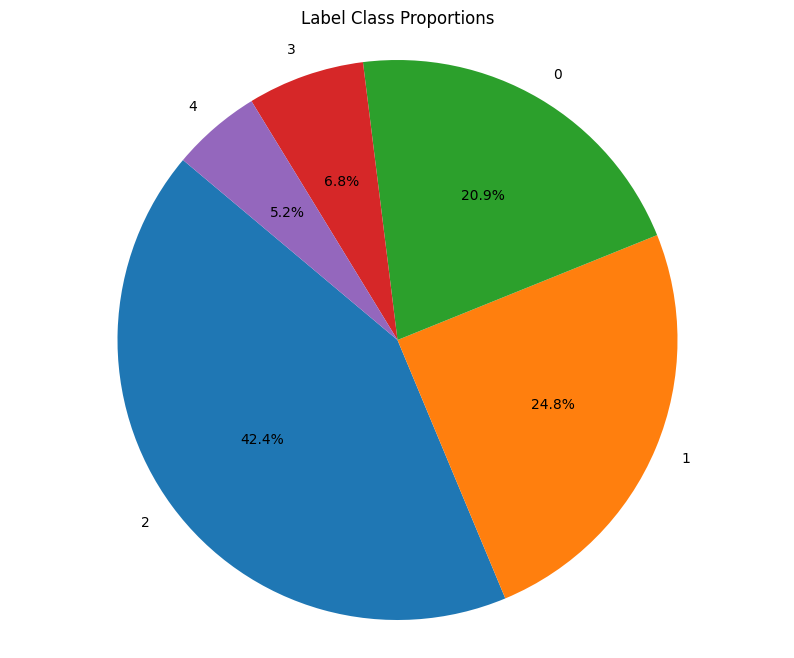

In [ ]:
import matplotlib.pyplot as plt

# 클래스 비율을 계산
class_counts = predict_propo['대주제'].value_counts(normalize=True)

# 파이차트를 위한 데이터와 라벨 준비
labels = class_counts.index
sizes = class_counts.values

# 파이차트 그리기
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 동그란 파이차트를 위해
plt.title('Label Class Proportions')
plt.show()

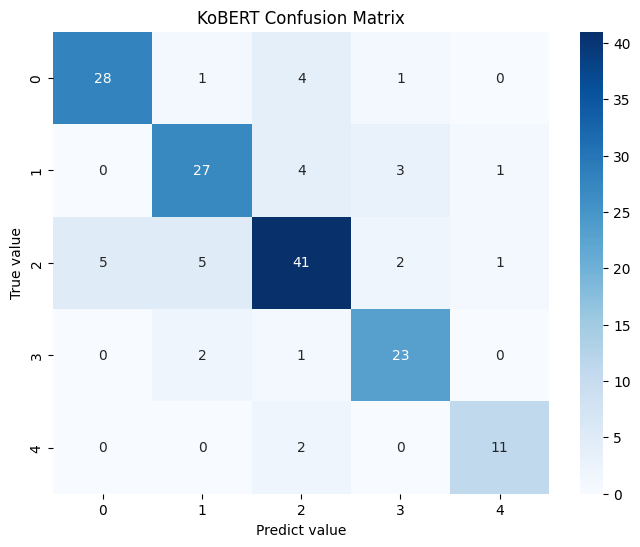

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동행렬 계산
cm = confusion_matrix(test, y_pred)

# 혼동행렬 시각화
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2", "3", "4"], yticklabels=["0", "1", "2", "3", "4"])
plt.ylabel('True value')
plt.xlabel('Predict value')
plt.title('KoBERT Confusion Matrix')
plt.show()


In [ ]:
# 학습 성능 평가

from sklearn.metrics import precision_score, recall_score

precision = precision_score(test, y_pred, average='macro')  # 또는 'micro', 'weighted'
recall = recall_score(test, y_pred, average='macro')  # 또는 'micro', 'weighted'

print(f"정밀도: {precision}")
print(f"재현율: {recall}")

정밀도: 0.8095264505609332
재현율: 0.8169972946443534


# source : https://github.com/SKTBrain/KoBERT